In [62]:
import torch
from EM300InverseNN import EM300InverseNN
# from EM300InverseNN2 import EM300InverseNN
from EM300CNN import EM300CNN

MODELS_PATH = "./saved/"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("Using device: {}".format(device))

model = EM300InverseNN()
print(model)
MODEL_NAME = "EM300InverseNN_E40_Bstart10_Decay0.8_Step5_NewModel"
# MODEL_NAME = "EM300InverseNN"
# MODEL_NAME = "EM300InverseNN_E40_Bstart10_BIncr20_Decay0.85_Step5_NewModel"
model.load_state_dict(torch.load(MODELS_PATH + MODEL_NAME, map_location=torch.device(device)))
# trained with 20 epochs currently, starting binary loss after 5
# Models in DIR:
# EM300InverseNN: 20 epochs, starting binary loss after 5
# EM300InverseNNE_40B_5: 40 epochs, starting binary loss after 10

surr = EM300CNN()
surr.eval()
surr.load_state_dict(torch.load(MODELS_PATH + "EM300CNNTunedLR0.001_gamma0.8_Every5_E50_Bs_4096", map_location=torch.device(device)))
torch.save(surr.state_dict(), MODELS_PATH + "EM300CNN.pt")
torch.save(model.state_dict(), MODELS_PATH + "EM300InverseNN.pt")

Using device: cpu
EM300InverseNN(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=256, bias=True)
  )
  (Tanh): Tanh()
)


In [51]:
import numpy as np
test_fn = "ex_vecs.txt"

with open(test_fn, "r") as f:
    sparams = [float(x.strip()) for x in f.read().split()]

print(len(sparams))
sparam_arr = np.zeros([3,54])
for i in range(0 , len(sparams), 3):
    sparam_arr[0, i // 3] = sparams[i]
    sparam_arr[1, i // 3] = sparams[i+1]
    sparam_arr[2, i // 3] = sparams[i+2]

print(sparam_arr[2])

162
[-0.9311 -0.8975 -0.8796 -0.799  -0.671  -0.47   -0.2004 -0.0275 -0.1609
  0.2897  0.3603  0.3912  0.4961  0.5961  0.6577  0.5888  0.2968 -0.0045
  0.0409  0.0639  0.0766  0.1369  0.2401  0.4128  0.6549  0.8048  0.6404
  0.1078  0.1369  0.1501  0.1965  0.2394  0.2466  0.1256 -0.2251 -0.6026
 -0.941  -0.9117 -0.8958 -0.8232 -0.704  -0.5092 -0.2334 -0.0321 -0.1372
  0.2637  0.3297  0.359   0.4601  0.5608  0.6303  0.5763  0.2887 -0.0416]


In [52]:
import numpy as np
from torch.utils.data import Dataset

RANDOM_SEED = 10
# Dataset object for DataLoader
class EM300Dataset(Dataset):
    def __init__(self, x_data_path, y_data_path):
        super().__init__()
        self.x = torch.tensor(np.load(x_data_path))
        self.y = torch.tensor(np.load(y_data_path))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0), self.y[idx]

# Load datasets
DATA_DIR = "/scratch/gpfs/sbfisher/EM300/data/"
# Create datasets for training the inverse model. 
# Use the training dataset from forward network
x_data_path = DATA_DIR + "x_data.npy"
y_data_path = DATA_DIR + "y_data.npy"

dataset = EM300Dataset(x_data_path, y_data_path)

generator = torch.Generator().manual_seed(RANDOM_SEED)
train, val, test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
# print(len(test.dataset[0][0]))
# batch_size = 512
# train_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

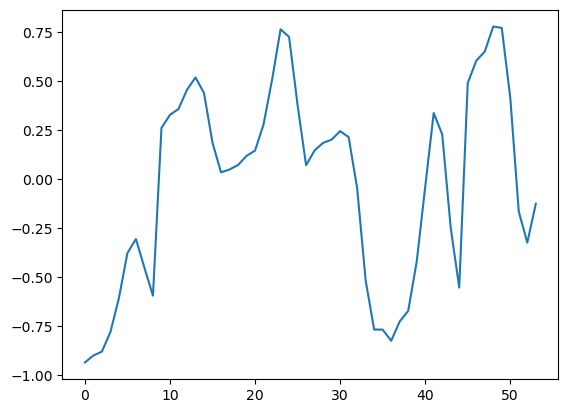

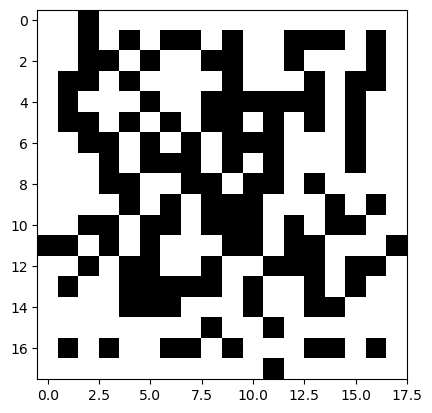

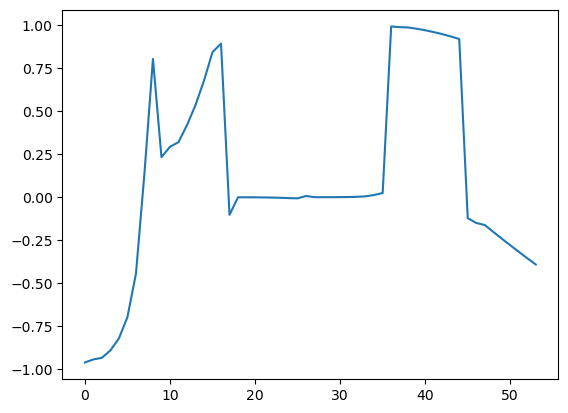

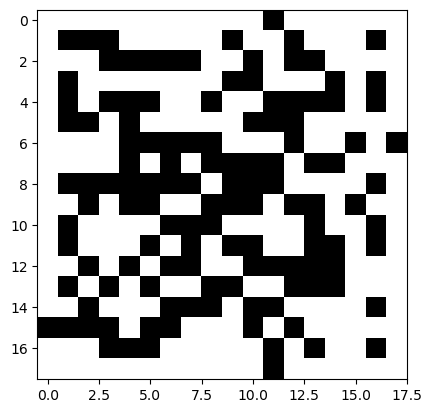

In [54]:
# print(dataset[0][1].shape)
ex_sparams = dataset[96][1]
ex_struct = dataset[96][0].squeeze()

plt.plot([i for i in range(54)], ex_sparams)
plt.figure()
plt.imshow(1 - ex_struct, cmap="gray")

# trial 0 flipped 90 degrees
ex_sparams = dataset[99][1]
ex_struct = dataset[99][0].squeeze()

plt.figure()
plt.plot([i for i in range(54)], ex_sparams)
plt.figure()
plt.imshow(1 - ex_struct, cmap="gray")

In [63]:
import matplotlib.pyplot as plt
import skrf as rf

def process_emx_sparam_file(sparam_file):
    # sparams will be s8p
    with open(sparam_file, 'r') as f:
        em_struct_net = rf.Network(f)

    freq = rf.Frequency(start=30, stop=100, npoints=71, unit='ghz')
    s = -1 * np.ones(71)  # random complex numbers
    # if not passed, will assume z0=50. name is optional but it's a good practice.
    short = rf.Network(frequency=freq, s=s, name='short')
    # print(short)
    # maybe need to make short only as long as em_struct_net??
    
    # Short all metal ports (should be last 4) to ground
    grounded = rf.connect(em_struct_net, 4, short, 0)
    grounded = rf.connect(grounded, 4, short, 0)
    grounded = rf.connect(grounded, 4, short, 0)
    grounded = rf.connect(grounded, 4, short, 0)

    # short top and bottom to ground, get sparam matrix
    net = rf.connect(rf.connect(grounded, 3, short, 0), 2, short, 0)
    params = net.s

    # with resulting 2x2 smat, take only at frequencies given
    freq = [30, 37, 40, 50, 60, 70, 80, 90, 100]
    idxs = np.array([x - 30 for x in freq])
    spect = np.zeros(54)
    n = 9
    spect[:n] = np.real(params[idxs,0,0]) # Re(s11)
    spect[n:2*n] = np.imag(params[idxs,0,0]) # Im(s11)
    spect[2*n:3*n] = np.real(params[idxs,0,1]) # Re(s12)
    spect[3*n:4*n] = np.imag(params[idxs,0,1]) # Im(s12)
    spect[4*n:5*n] = np.real(params[idxs,1,1]) # Re(s22)
    spect[5*n:6*n] = np.imag(params[idxs,1,1]) # Im(s22)
    
    return spect

def predict(idx=10, save=False, from_known=False, known_idx=0, save_csv=False, sparams=[]):
    with torch.no_grad():
        struct, spectrum = test[idx]

        if from_known:
            spectrum=torch.tensor(sparams)
        
        output = model(spectrum.float(), m=1, use_threshold=True)
        # print(output.shape)
        struct = struct.squeeze()
        output = output.squeeze()

        # Print Test dataset item and spectrum
        if not from_known:
            plt.imshow(1 - struct, cmap="gray")
            plt.title("Test Set Design, D")
            plt.xticks([])  # Remove x-axis labels and ticks
            plt.yticks([])  # Remove y-axis labels and ticks

        if save:
            save_fig_name = "/scratch/gpfs/sbfisher/EM300/inverse_tests/D_ex{}.png".format(idx)
            plt.savefig(save_fig_name, dpi=300)

        test_spectrum = spectrum.detach().numpy()
        pred_spectrum_of_d = surr(struct.float().unsqueeze(0).unsqueeze(0)).squeeze()
    
        # apply hard thresholding to output of neural network
        # output = torch.where(output > 0.35, 1, 0) #hard thresholding to 1s or 0s
        output = torch.where(output > 0.5, 1, 0) #hard thresholding to 1s or 0s

        # save output to tests folder for emx processing
        test_file = "/scratch/gpfs/sbfisher/EM300/tests/test_struct.npy"
        np.save(test_file, output)
        
        plt.figure()
        plt.imshow(1 - output, cmap="gray")
        plt.title("Inverse Predicted Design, D'")
        plt.xticks([])  # Remove x-axis labels and ticks
        plt.yticks([])  # Remove y-axis labels and ticks
        if save:
            save_fig_name = "/scratch/gpfs/sbfisher/EM300/inverse_tests/Dprime_ex{}.png".format(idx)
            plt.savefig(save_fig_name, dpi=300)
        pred_spectrum_of_dprime = surr(output.unsqueeze(0).unsqueeze(0)).squeeze()

        # Get spectrum predicted by running EMX on D'
        emx_result_path = "/scratch/gpfs/sbfisher/EM300/tests/test_spect.s8p"
        yn = input("Was emx run for this struct number? y/n")
        emx_spect = np.array([])
        if yn.lower() == "y":
            emx_spectrum = "/scratch/gpfs/sbfisher/EM300/tests/test_spect.s8p"
            emx_spect = process_emx_sparam_file(emx_spectrum)
            # plt.figure()
            # plt.plot(emx_spect)
            # plt.title("Spectrum predicted by emx for D'")
        else:
            print("you typed no or invalid input")

        # S11
        #############################################
        n = 9
        s11_idxs = list(range(0, n))
        s11_s = test_spectrum[s11_idxs]
        s11_sprime = pred_spectrum_of_dprime[s11_idxs]
        s11_spred_of_d = pred_spectrum_of_d[s11_idxs]
        s11_emx = emx_spect[s11_idxs]

        
        s11_im_idxs = list(range(n, n*2))
        s11_im_s = test_spectrum[s11_im_idxs]
        s11_im_sprime = pred_spectrum_of_dprime[s11_im_idxs]
        s11_im_spred_of_d = pred_spectrum_of_d[s11_im_idxs]
        s11_im_emx = emx_spect[s11_im_idxs]

        plt.figure()
        freq = [30, 37, 40, 50, 60, 70, 80, 90, 100]
        plt.subplot(1,2,1)
        plt.plot(freq, s11_s)
        plt.plot(freq, s11_sprime)
        # plt.plot(freq, s11_spred_of_d)
        plt.plot(freq, s11_emx)
        plt.ylim([-1, 1])
        plt.legend(["S", "S'", "EMX Simulation(D')"])
        plt.title("various Re(s11)")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Re(s11)")
    
        plt.subplot(1,2,2)
        s11_mag_s = np.abs(1j*s11_im_s+s11_s)
        s11_mag_sprime = np.abs(1j*s11_im_sprime+s11_sprime)
        s11_mag_spred_of_d = np.abs(1j*s11_im_spred_of_d+s11_spred_of_d)
        s11_mag_emx = np.abs(1j*s11_im_emx+s11_emx)
        plt.plot(freq, s11_mag_s)
        plt.plot(freq, s11_mag_sprime)
        # plt.plot(freq, s11_mag_spred_of_d)
        plt.plot(freq, s11_mag_emx)
        plt.ylim([-1.5, 1.5])
        plt.legend(["S", "S'", "EMX Simulation(D')"])
        plt.title("various Mag(s11)")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Mag(s11)")
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

        if save:
            save_fig_name = "/scratch/gpfs/sbfisher/EM300/inverse_tests/s11_ex{}.png".format(idx)
            plt.savefig(save_fig_name, dpi=300)

        # S12
        ##################################################
        s12_idxs = list(range(n*2, n*3))
        
        s12_s = test_spectrum[s12_idxs]
        s12_sprime = pred_spectrum_of_dprime[s12_idxs]
        s12_spred_of_d = pred_spectrum_of_d[s12_idxs]
        s12_emx = emx_spect[s12_idxs]
        
        s12_im_idxs = list(range(n*3, n*4))
        s12_im_s = test_spectrum[s12_im_idxs]
        s12_im_sprime = pred_spectrum_of_dprime[s12_im_idxs]
        s12_im_spred_of_d = pred_spectrum_of_d[s12_im_idxs]
        s12_im_emx = emx_spect[s12_im_idxs]
        plt.figure()
        plt.subplot(1,2,1)
        plt.plot(freq, s12_s)
        plt.plot(freq, s12_sprime)
        # plt.plot(freq, s12_spred_of_d)
        plt.plot(freq, s12_emx)
        plt.ylim([-1, 1])
        plt.legend(["S", "S'", "EMX Simulation(D')"])
        plt.title("various Re(s21)")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Re(s21)")
    
        plt.subplot(1,2,2)
        s12_mag_s = np.abs(1j*s12_im_s+s12_s)
        s12_mag_sprime = np.abs(1j*s12_im_sprime+s12_sprime)
        s12_mag_spred_of_d = np.abs(1j*s12_im_spred_of_d+s12_spred_of_d)
        s12_mag_emx = np.abs(1j*s12_im_emx+s12_emx)
        plt.plot(freq, s12_mag_s)
        plt.plot(freq, s12_mag_sprime)
        # plt.plot(freq, s12_mag_spred_of_d)
        plt.plot(freq, s12_mag_emx)
        plt.ylim([-1.5, 1.5])
        plt.legend(["S", "S'", "EMX Simulation(D')"])
        plt.title("various Mag(s21)")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Mag(s21)")
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

        if save:
            save_fig_name = "/scratch/gpfs/sbfisher/EM300/inverse_tests/s12_ex{}.png".format(idx)
            plt.savefig(save_fig_name, dpi=300)

        #############################################################################

        # S22
        ##################################################
        s22_idxs = list(range(n*4, n*5))
        
        s22_s = test_spectrum[s22_idxs]
        s22_sprime = pred_spectrum_of_dprime[s22_idxs]
        s22_spred_of_d = pred_spectrum_of_d[s22_idxs]
        s22_emx = emx_spect[s22_idxs]
        
        s22_im_idxs = list(range(n*5, n*6))
        s22_im_s = test_spectrum[s22_im_idxs]
        s22_im_sprime = pred_spectrum_of_dprime[s22_im_idxs]
        s22_im_spred_of_d = pred_spectrum_of_d[s22_im_idxs]
        s22_im_emx = emx_spect[s22_im_idxs]
        plt.figure()
        plt.subplot(1,2,1)
        plt.plot(freq, s22_s)
        plt.plot(freq, s22_sprime)
        # plt.plot(freq, s22_spred_of_d)
        plt.plot(freq, s22_emx)
        plt.ylim([-1, 1])
        plt.legend(["S", "S'", "CNN(D)", "EMX Simulation(D')"])
        plt.title("various Re(s22)")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Re(s22)")
    
        plt.subplot(1,2,2)
        s22_mag_s = np.abs(1j*s22_im_s+s22_s)
        s22_mag_sprime = np.abs(1j*s22_im_sprime+s22_sprime)
        s22_mag_spred_of_d = np.abs(1j*s22_im_spred_of_d+s22_spred_of_d)
        s22_mag_emx = np.abs(1j*s22_im_emx+s22_emx)
        plt.plot(freq, s22_mag_s)
        plt.plot(freq, s22_mag_sprime)
        # plt.plot(freq, s22_mag_spred_of_d)
        plt.plot(freq, s22_mag_emx)
        plt.ylim([-1.5, 1.5])
        plt.legend(["S", "S'", "EMX Simulation(D')"])
        plt.title("various Mag(s22)")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Mag(s22)")
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

        if save:
            save_fig_name = "/scratch/gpfs/sbfisher/EM300/inverse_tests/s22_ex{}.png".format(idx)
            plt.savefig(save_fig_name, dpi=300)

        #############################################################################
        
        plt.figure()
        plt.plot(test_spectrum)
        
        plt.plot(pred_spectrum_of_dprime)
        if yn.lower() == "y":
            plt.plot(emx_spect)
        # plt.plot(pred_spectrum_of_d)
        plt.title("Compared spectrums")
        plt.legend(["Input Spectrum", "Predicted of D' by CNN", "Predicted of D' by EMX", "Predicted of D"])
        for i in range(9, 54, 9):
            plt.axvline(x = i, color = 'y')
        
        # m = 20
        # print(1/2 * (torch.tanh(m * (output - 1/2)) + 1))
        # print(struct)

        if save_csv:
            save_struct_path = "/scratch/gpfs/sbfisher/EM300/inverse_tests/struct{}.csv".format(idx)
            save_data_path = "/scratch/gpfs/sbfisher/EM300/inverse_tests/sparams{}.csv".format(idx)
    
            s = np.array(output)
            sparams = np.array(spectrum)
            np.savetxt(save_struct_path, s.squeeze(), delimiter=",")
            np.savetxt(save_data_path, sparams.squeeze(), delimiter=",")

        return output

    

/home/sbfisher/.conda/envs/CadenceEnv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Was emx run for this struct number? y/n n


you typed no or invalid input
tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0

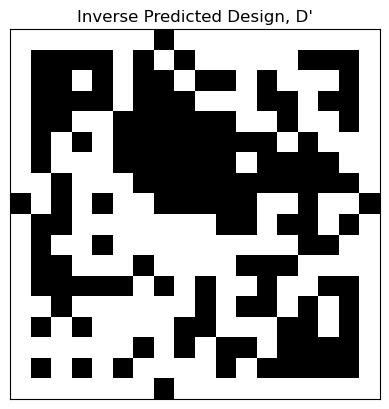

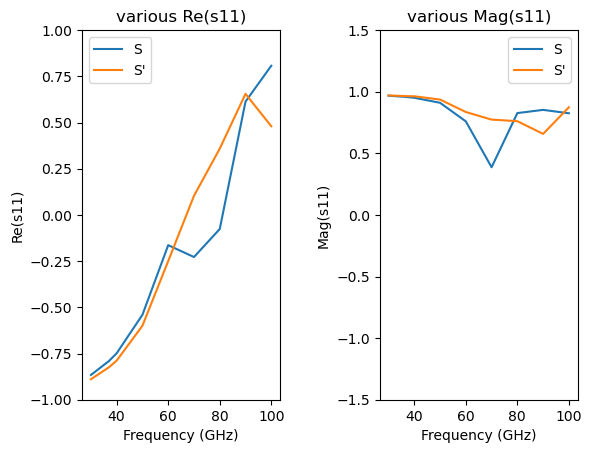

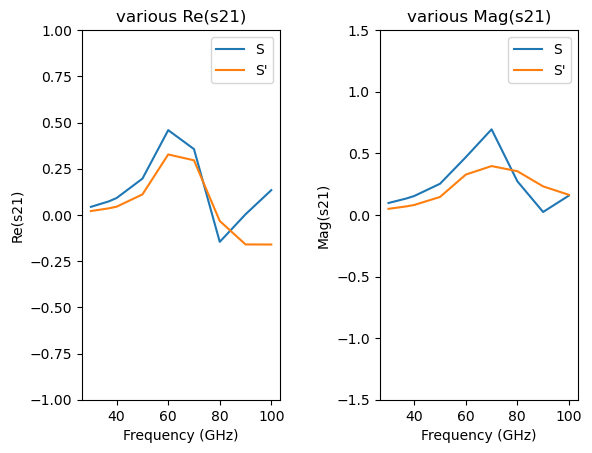

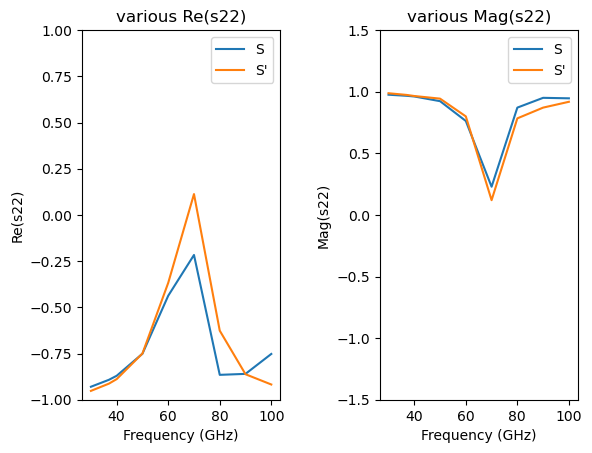

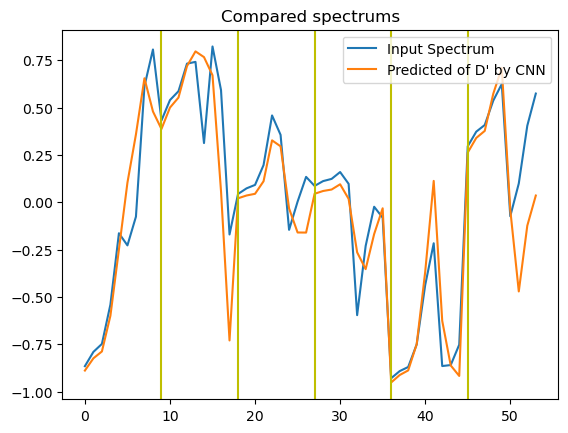

In [10]:
test1 = predict(save=False, from_known=True, save_csv=False, sparams=sparam_arr[0])
print(test1)
structs = [test1]

Was emx run for this struct number? y/n n


you typed no or invalid input


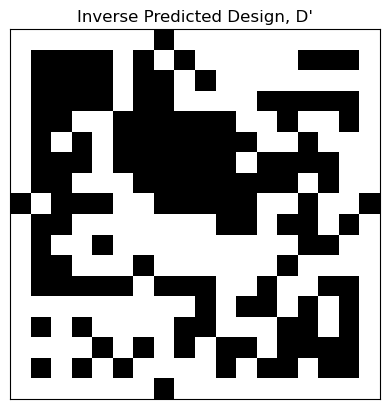

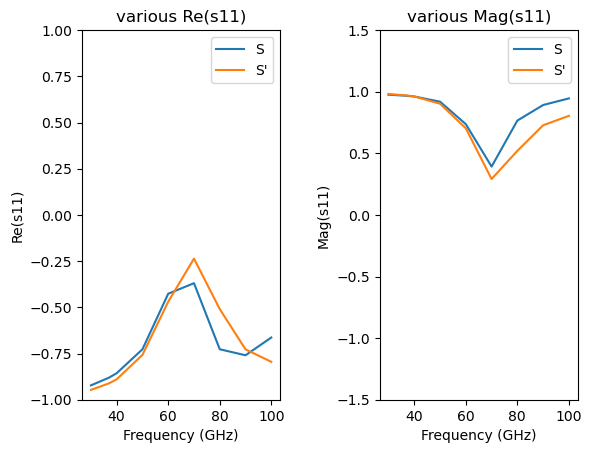

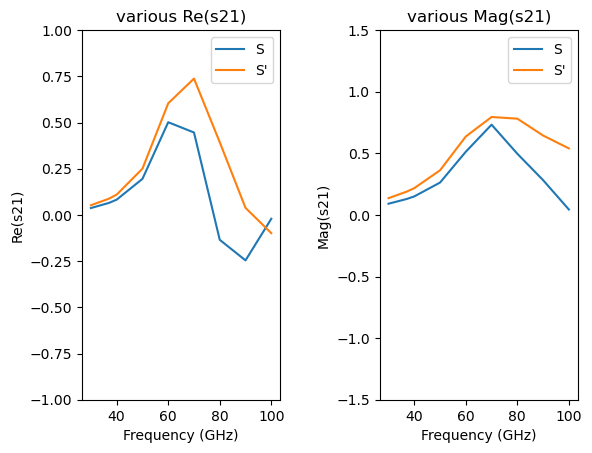

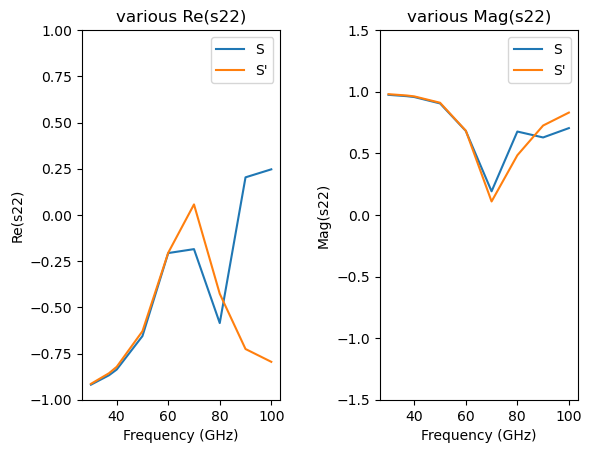

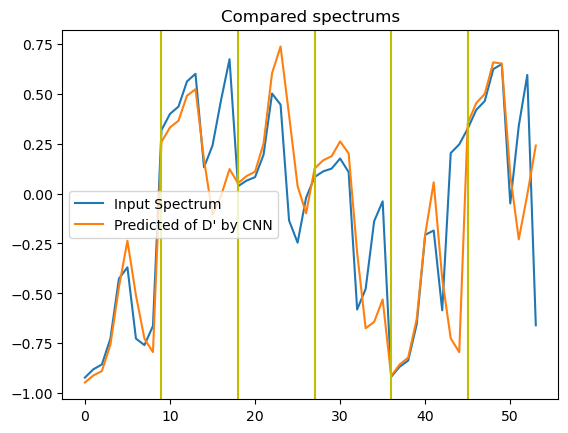

In [11]:
test2 = predict(save=False, from_known=True, save_csv=False, sparams=sparam_arr[1])
structs.append(test2)

Was emx run for this struct number? y/n n


you typed no or invalid input


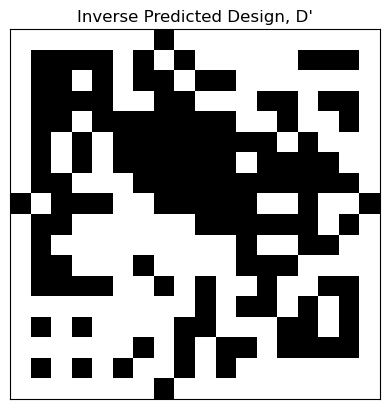

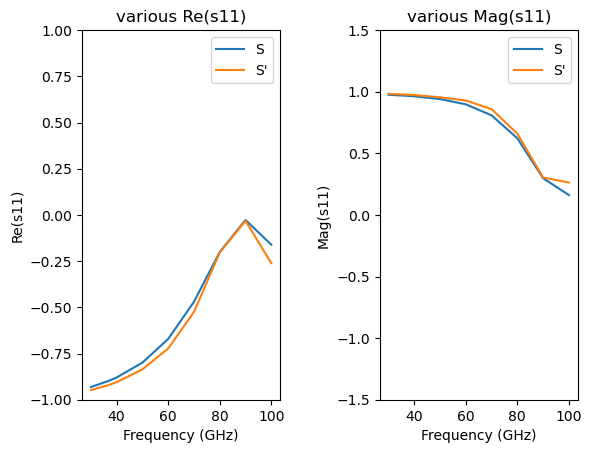

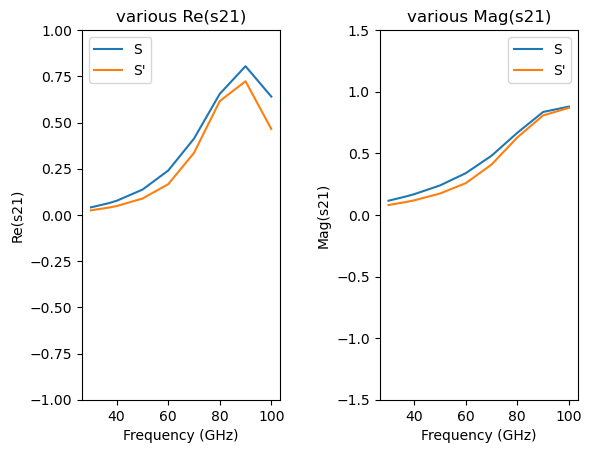

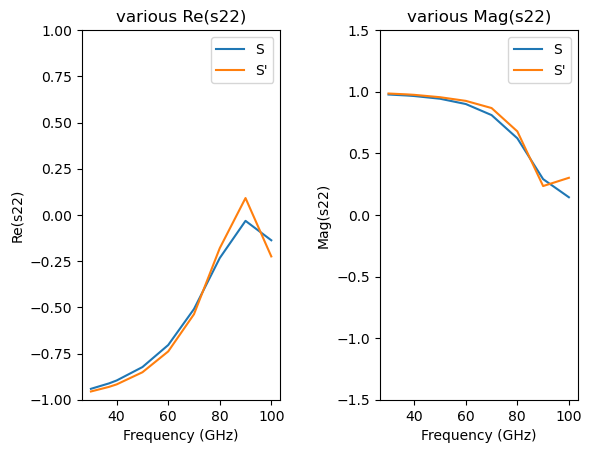

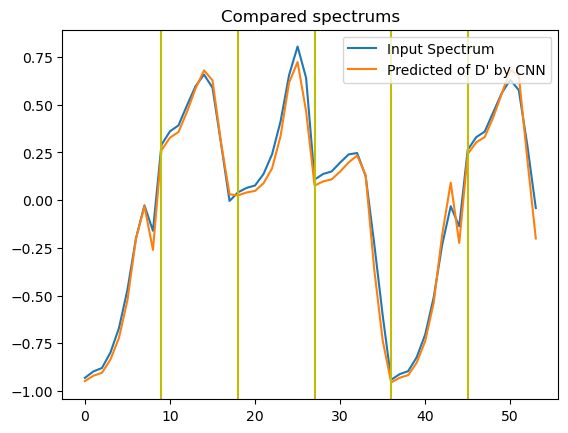

In [28]:
test3 = predict(save=False, from_known=True, save_csv=False, sparams=sparam_arr[2])
structs.append(test3)

In [33]:
structs = np.array(structs)
print(structs.shape)

save_struct_dir = "/scratch/gpfs/sbfisher/EM300/results/"
np.savetxt(save_struct_dir + "test1.csv", structs[0], delimiter=",", fmt="%.3e")
np.savetxt(save_struct_dir + "test2.csv", structs[1], delimiter=",", fmt="%.3e")
np.savetxt(save_struct_dir + "test3.csv", structs[2], delimiter=",", fmt="%.3e")




(3, 18, 18)


Was emx run for this struct number? y/n n


you typed no or invalid input


IndexError: index 0 is out of bounds for axis 0 with size 0

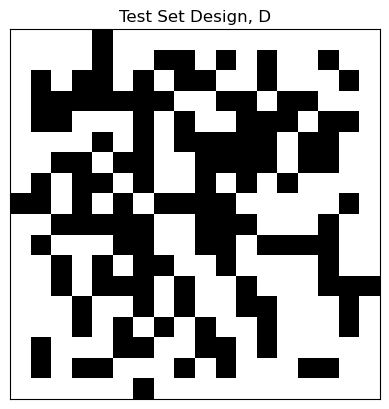

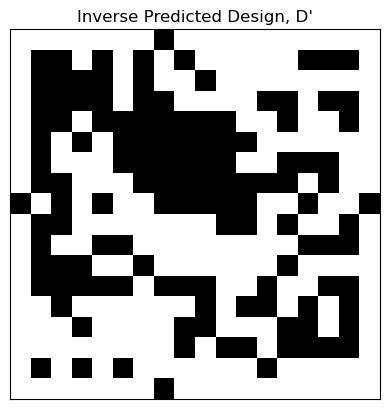

In [73]:
predict(462, save=True, save_csv=True) #462 interesting non-trivial

Was emx run for this struct number? y/n n


you typed no or invalid input


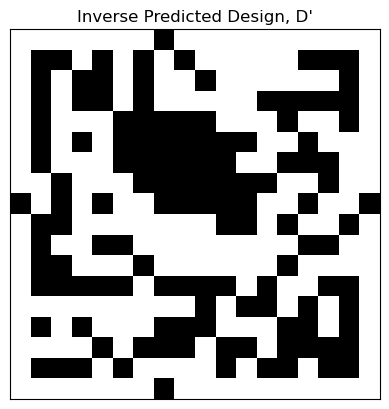

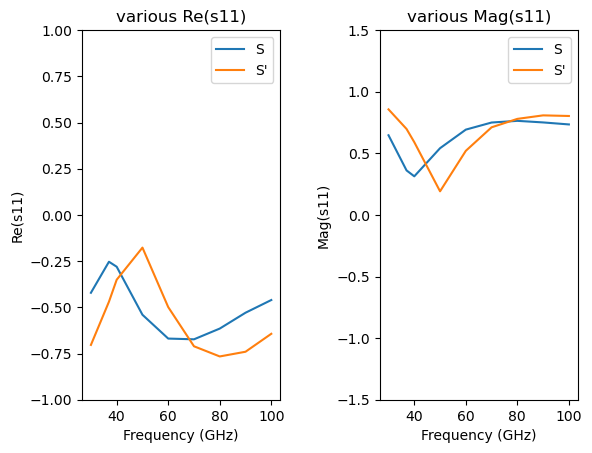

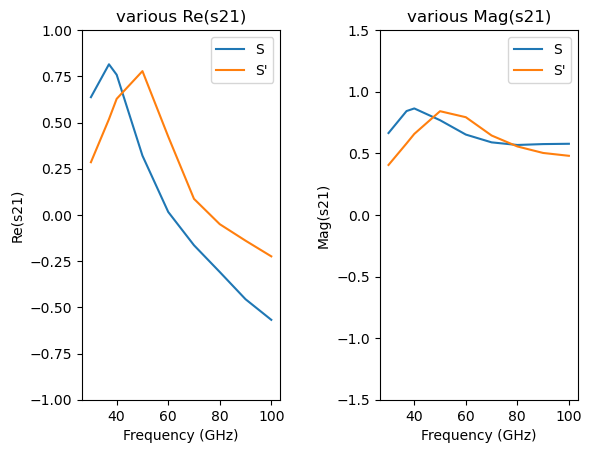

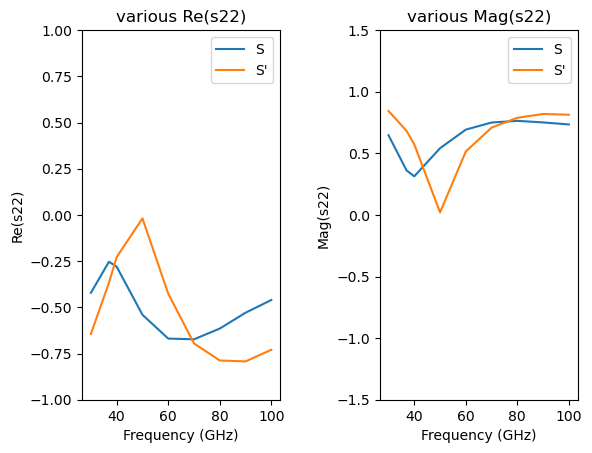

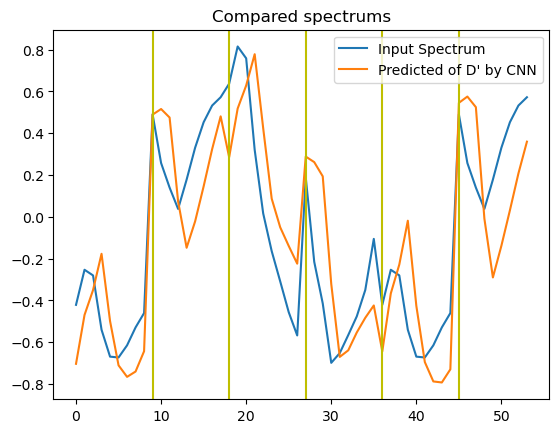

In [43]:
predict(save=False,from_known=True,known_idx=0)

Was emx run for this struct number? y/n n


you typed no or invalid input


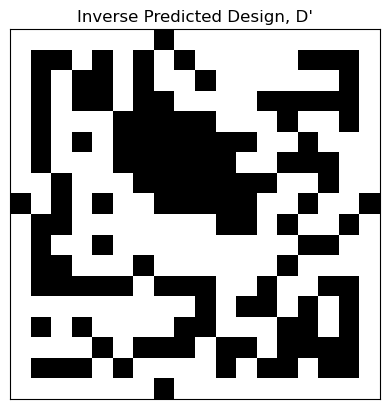

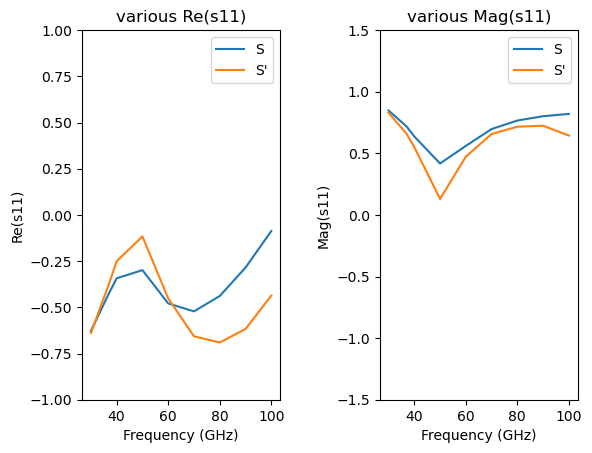

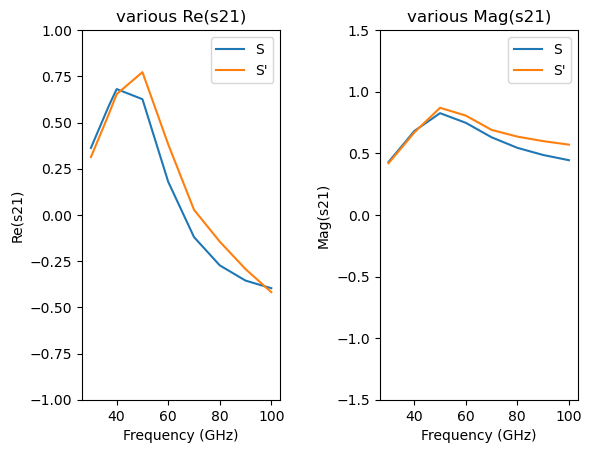

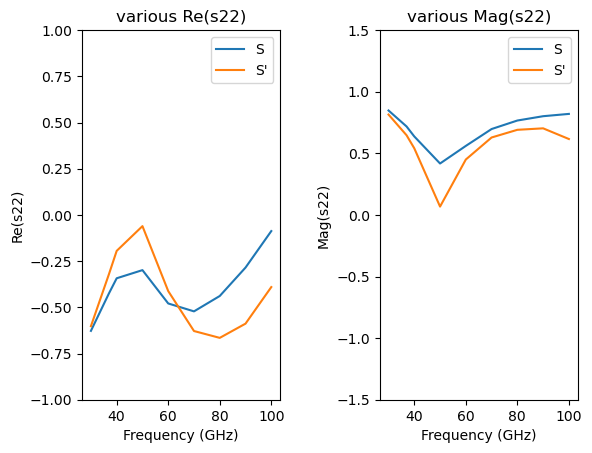

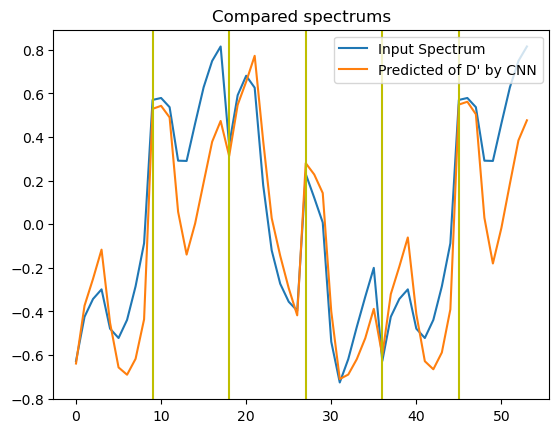

In [44]:
predict(save=False,from_known=True,known_idx=1)

Was emx run for this struct number? y/n n


you typed no or invalid input


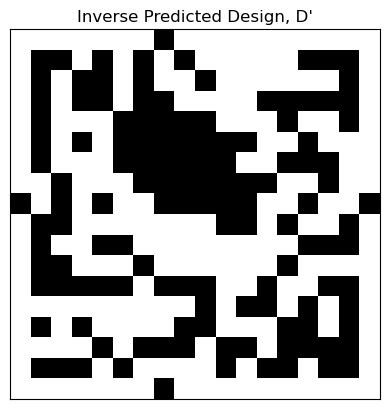

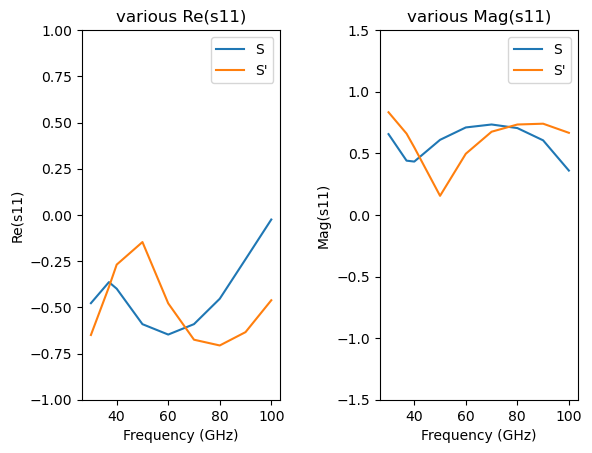

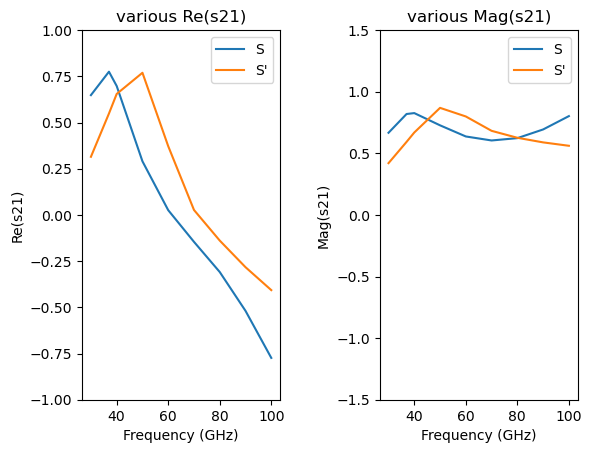

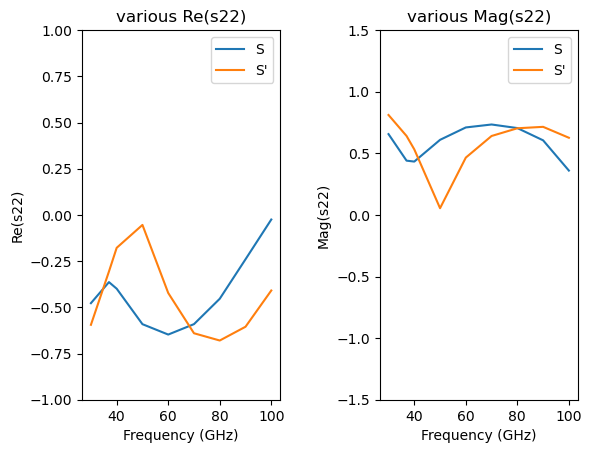

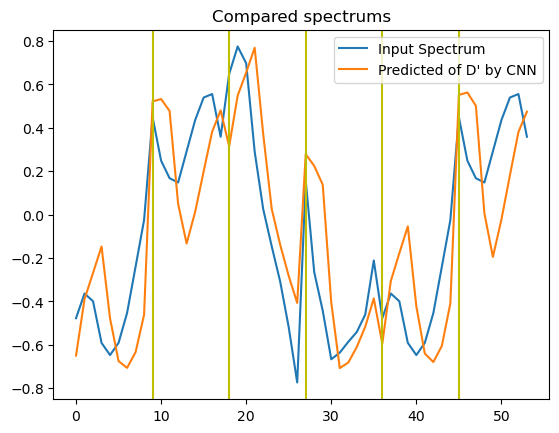

In [45]:
predict(save=False,from_known=True,known_idx=2)

Was emx run for this struct number? y/n y


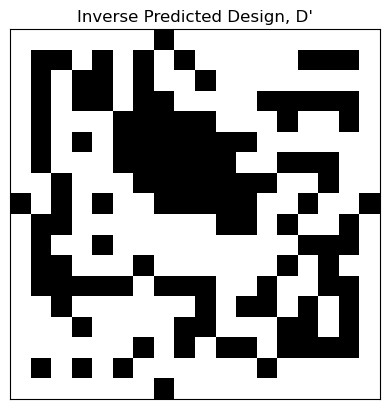

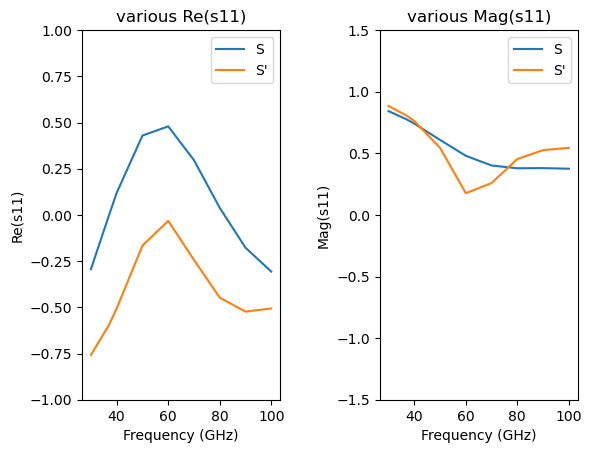

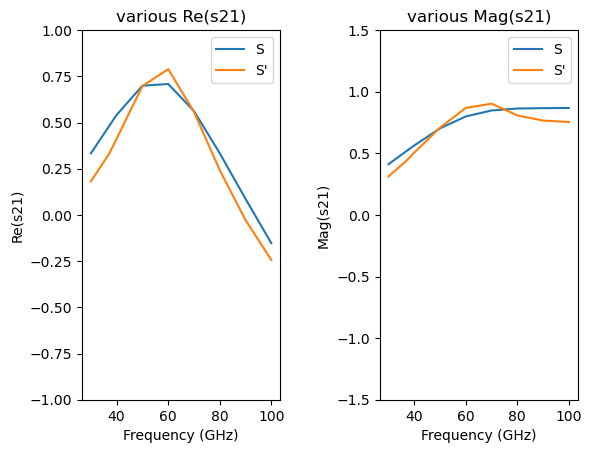

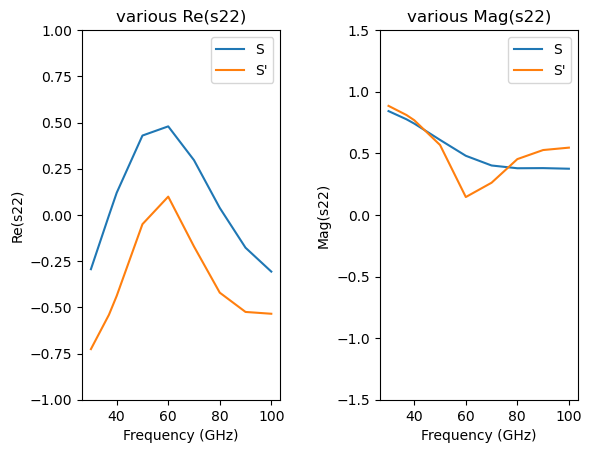

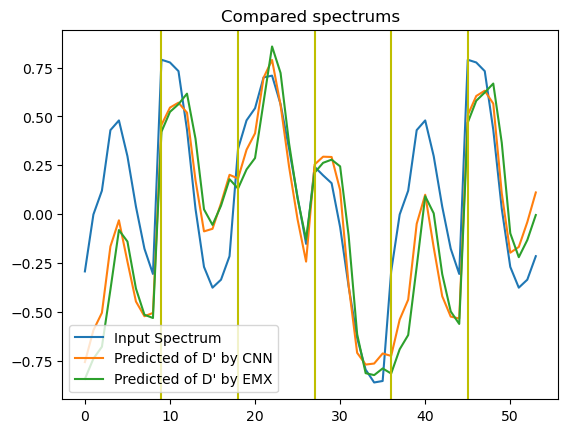

In [51]:
predict(save=False,from_known=True,known_idx=3)

Was emx run for this struct number? y/n y


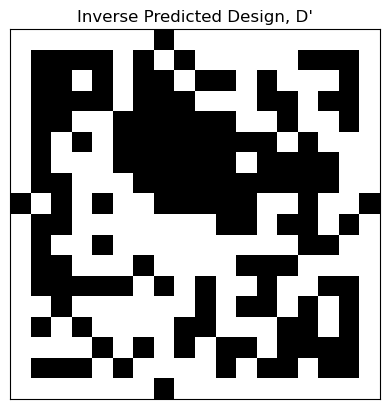

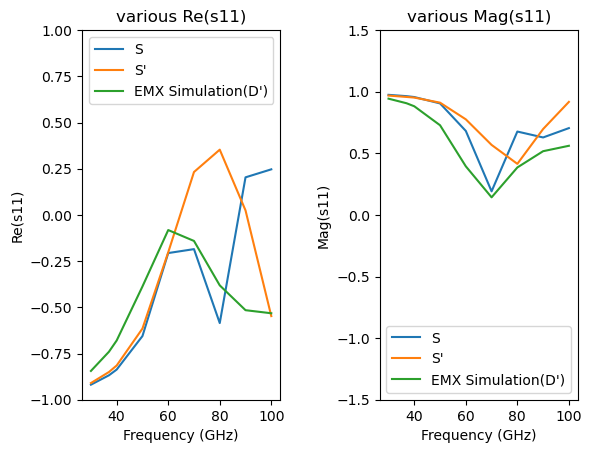

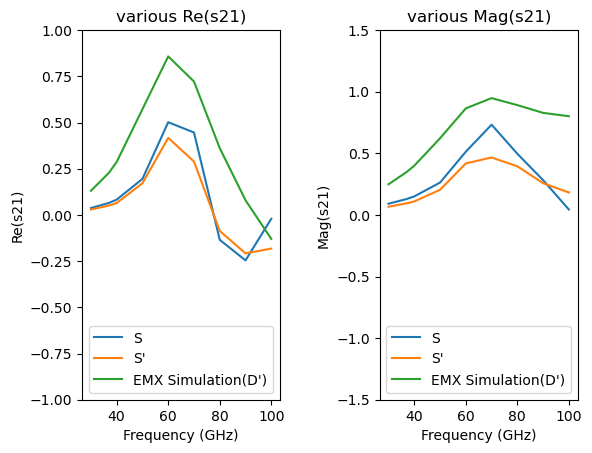

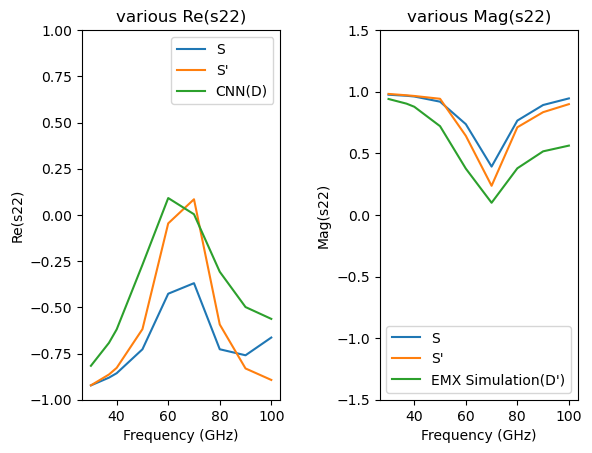

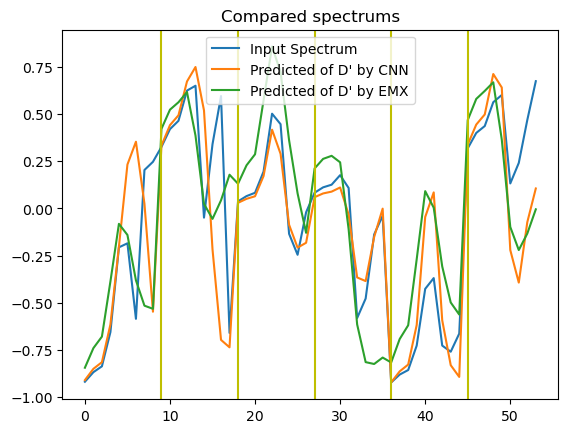

In [43]:
sparams = sparam_arr[1].copy()
temp = sparams[36:].copy()
sparams[36:] = sparams[:18].copy()
sparams[:18] = temp
# print(temp.shape)
# print(sparams)
# print(sparam_arr[1])

test1 = predict(save=False, from_known=True, save_csv=False, sparams=sparams)

Was emx run for this struct number? y/n n


you typed no or invalid input


IndexError: index 0 is out of bounds for axis 0 with size 0

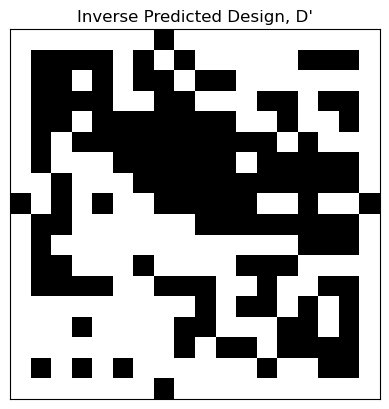

In [72]:
sparams = sparam_arr[2].copy()
temp = sparams[36:].copy()
sparams[36:] = sparams[:18].copy()
sparams[:18] = temp
noise = np.random.normal(0, 0.4, (54,))
sparams += noise

test3 = predict(save=False, from_known=True, save_csv=False, sparams=sparams)

Was emx run for this struct number? y/n y


tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1

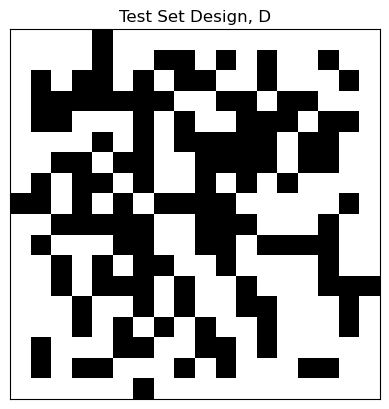

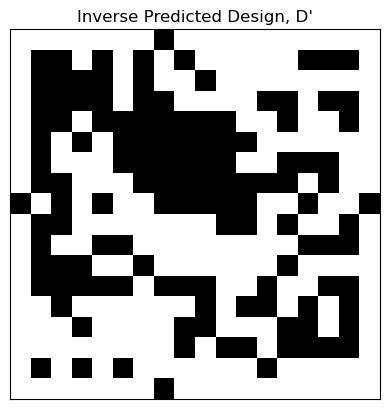

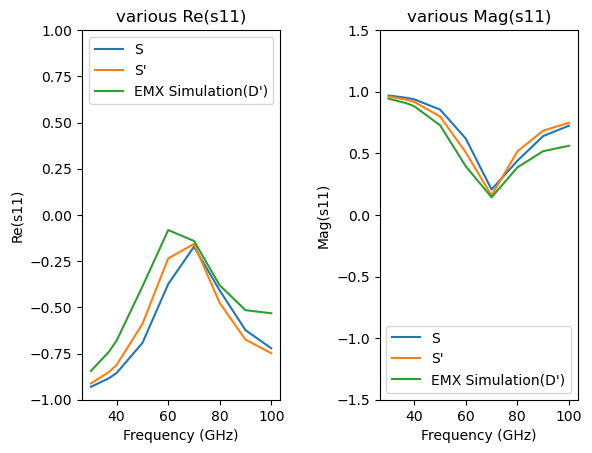

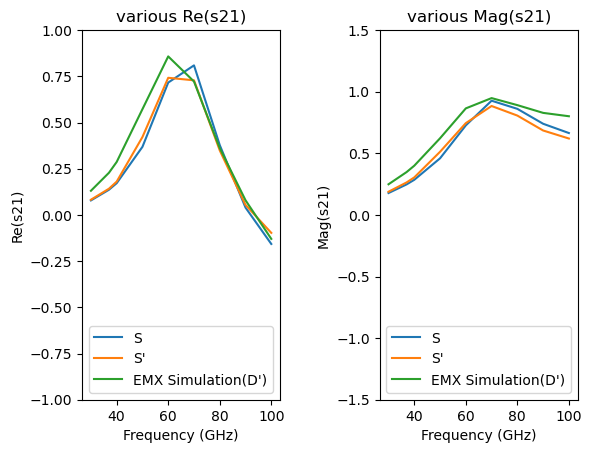

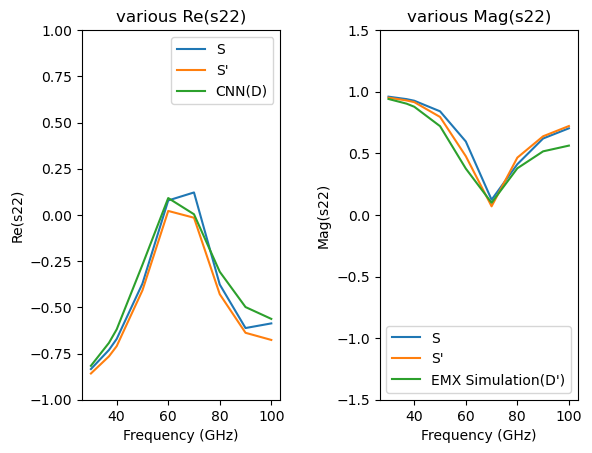

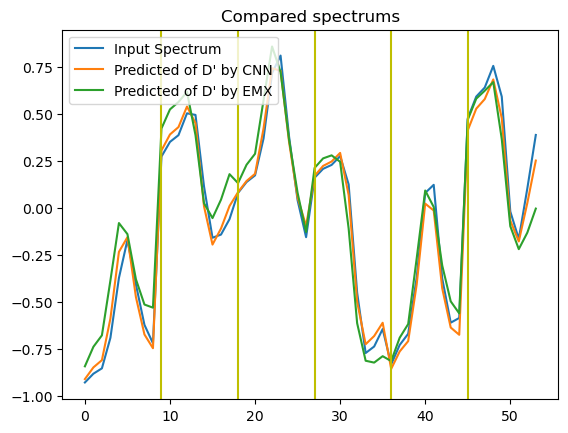

In [76]:
predict(462, save=False, save_csv=False) #462 interesting non-trivial

Was emx run for this struct number? y/n y


tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1

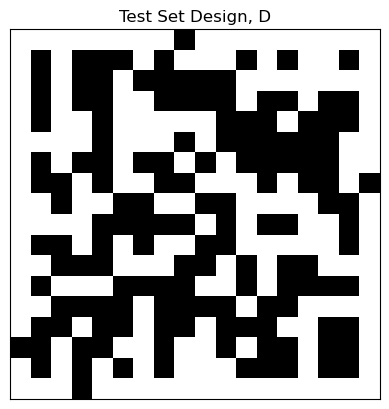

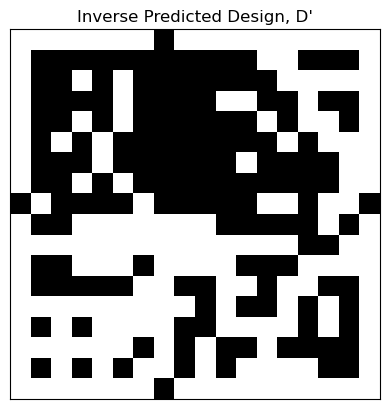

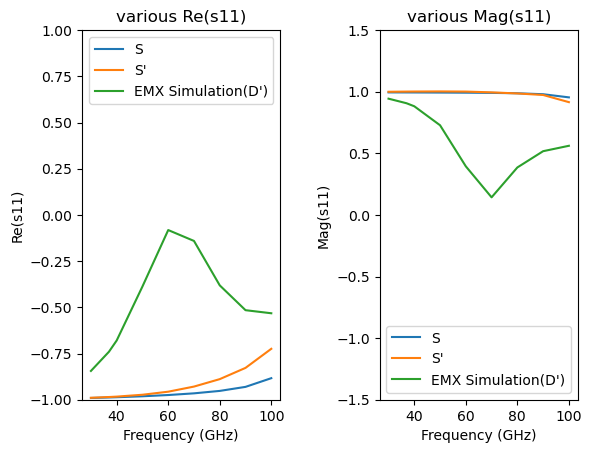

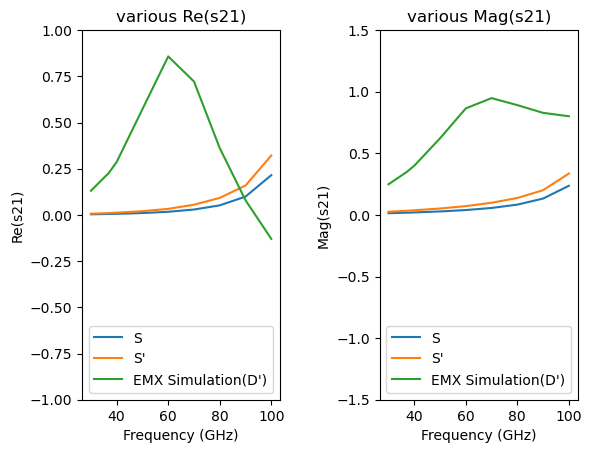

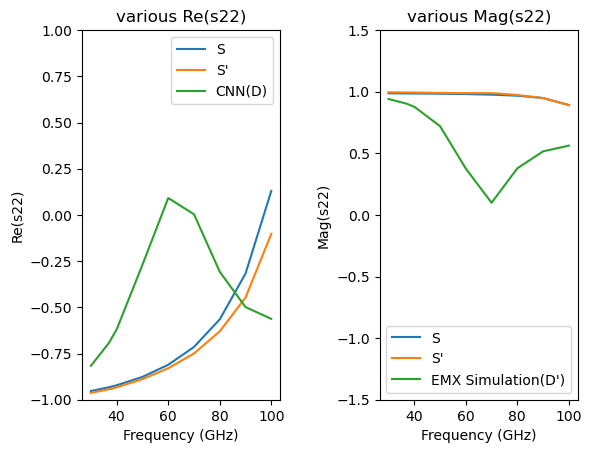

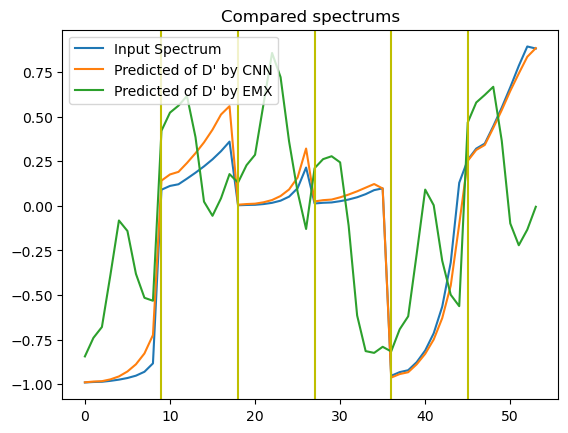

In [83]:
predict(668, save=False, save_csv=False) #462 interesting non-trivial